# Sound Emotion Detection System

This notebook trains a deep learning model to detect emotions from audio files using the TESS Toronto emotional speech dataset.

## Dataset Structure:
- **OAF_***: Older actress female recordings
- **YAF_***: Younger actress female recordings
- **Emotions**: angry, disgust, fear, happy, neutral, sad, pleasant_surprise

## Features:
- **MFCCs**: Mel-frequency cepstral coefficients
- **Chroma**: Pitch-related features
- **Spectral Contrast**: Frequency band differences
- **Zero Crossing Rate**: Signal changes
- **Spectral Rolloff**: Frequency distribution

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Define data path and parameters
data_dir = "../data/sound_data/TESS Toronto emotional speech set data"
sample_rate = 22050  # Standard audio sample rate
duration = 3  # Duration in seconds (will pad/crop to this)
n_mfcc = 40  # Number of MFCC features
n_fft = 2048  # FFT window size
hop_length = 512  # Hop length for STFT

print(f"Data directory: {data_dir}")
print(f"Sample rate: {sample_rate} Hz")
print(f"Duration: {duration} seconds")
print(f"MFCC features: {n_mfcc}")

Data directory: ../data/sound_data/TESS Toronto emotional speech set data
Sample rate: 22050 Hz
Duration: 3 seconds
MFCC features: 40


In [3]:
# Explore dataset structure
emotions = []
file_counts = {}

for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        # Extract emotion from folder name
        if '_' in folder:
            emotion = folder.split('_')[-1]
            if emotion not in emotions:
                emotions.append(emotion)
        
        # Count files
        file_path = os.path.join(data_dir, folder)
        file_count = len([f for f in os.listdir(file_path) if f.endswith('.wav')])
        file_counts[folder] = file_count

print("Dataset Structure:")
for folder, count in file_counts.items():
    print(f"  {folder}: {count} files")

print(f"\nEmotions found: {emotions}")
print(f"Total files: {sum(file_counts.values())}")

Dataset Structure:
  YAF_disgust: 200 files
  OAF_Pleasant_surprise: 200 files
  OAF_happy: 200 files
  YAF_sad: 200 files
  TESS Toronto emotional speech set data: 0 files
  YAF_happy: 200 files
  YAF_neutral: 200 files
  OAF_Fear: 200 files
  OAF_angry: 200 files
  YAF_pleasant_surprised: 200 files
  YAF_fear: 200 files
  OAF_neutral: 200 files
  OAF_disgust: 200 files
  YAF_angry: 200 files
  OAF_Sad: 200 files

Emotions found: ['disgust', 'surprise', 'happy', 'sad', 'neutral', 'Fear', 'angry', 'surprised', 'fear', 'Sad']
Total files: 2800


In [4]:
def extract_audio_features(file_path, max_pad_length=173):
    """
    Extract comprehensive audio features from audio file
    Note: max_pad_length refers to time frames, not audio samples
    """
    try:
        # Load audio file (full duration)
        y, sr = librosa.load(file_path, duration=duration, sr=sample_rate)
        
        features = {}
        
        # 1. MFCCs (most important for speech emotion)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        # Pad or truncate to consistent time frames
        if mfccs.shape[1] < max_pad_length:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_pad_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_length]
        features['mfcc'] = mfccs
        
        # 2. Chroma features (pitch-related)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
        if chroma.shape[1] < max_pad_length:
            chroma = np.pad(chroma, ((0, 0), (0, max_pad_length - chroma.shape[1])), mode='constant')
        else:
            chroma = chroma[:, :max_pad_length]
        features['chroma'] = chroma
        
        # 3. Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
        if spectral_contrast.shape[1] < max_pad_length:
            spectral_contrast = np.pad(spectral_contrast, ((0, 0), (0, max_pad_length - spectral_contrast.shape[1])), mode='constant')
        else:
            spectral_contrast = spectral_contrast[:, :max_pad_length]
        features['spectral_contrast'] = spectral_contrast
        
        # 4. Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
        if zcr.shape[1] < max_pad_length:
            zcr = np.pad(zcr, ((0, 0), (0, max_pad_length - zcr.shape[1])), mode='constant')
        else:
            zcr = zcr[:, :max_pad_length]
        features['zcr'] = zcr
        
        # 5. Spectral Rolloff
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
        if spectral_rolloff.shape[1] < max_pad_length:
            spectral_rolloff = np.pad(spectral_rolloff, ((0, 0), (0, max_pad_length - spectral_rolloff.shape[1])), mode='constant')
        else:
            spectral_rolloff = spectral_rolloff[:, :max_pad_length]
        features['spectral_rolloff'] = spectral_rolloff
        
        # 6. RMS Energy
        rms = librosa.feature.rms(y=y, hop_length=hop_length)
        if rms.shape[1] < max_pad_length:
            rms = np.pad(rms, ((0, 0), (0, max_pad_length - rms.shape[1])), mode='constant')
        else:
            rms = rms[:, :max_pad_length]
        features['rms'] = rms
        
        return features
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

Sample file: ../data/sound_data/TESS Toronto emotional speech set data/YAF_disgust/YAF_date_disgust.wav

Feature shapes:
  mfcc: (40, 173)
  chroma: (12, 173)
  spectral_contrast: (7, 173)
  zcr: (1, 173)
  spectral_rolloff: (1, 173)
  rms: (1, 173)


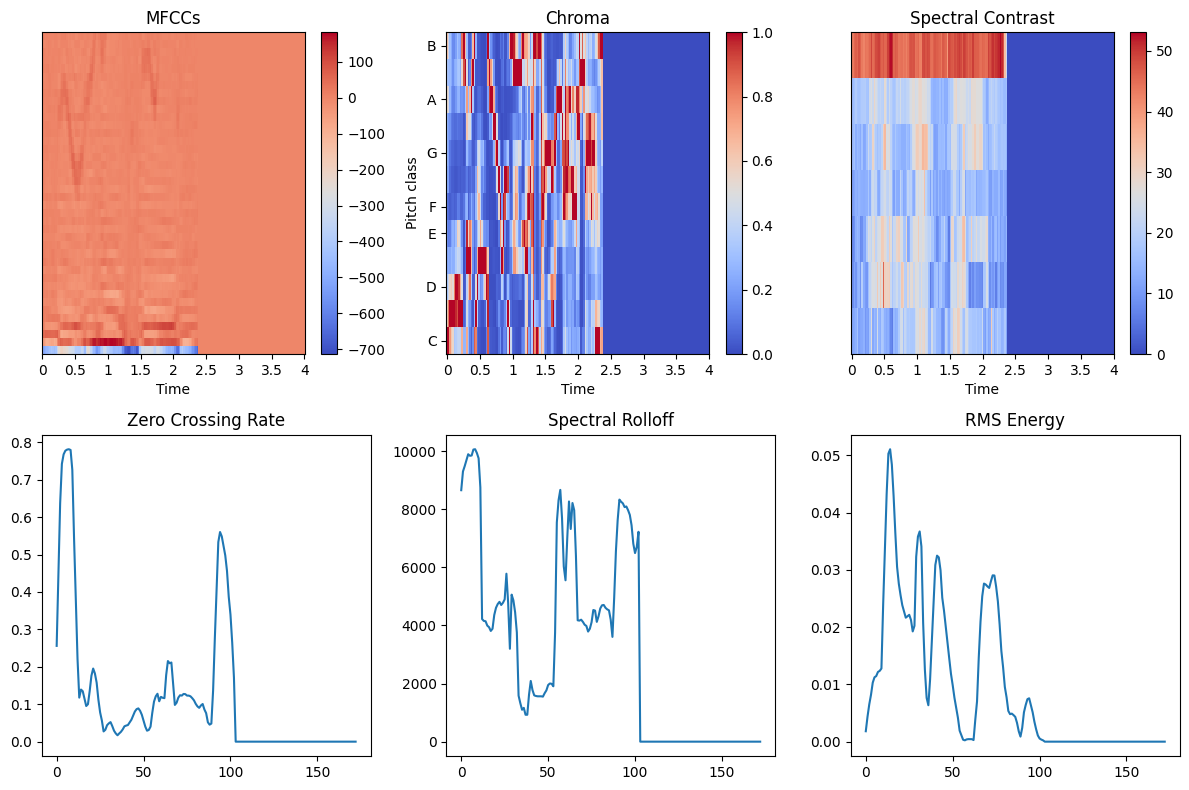

In [5]:
# Test feature extraction on a sample file
sample_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
sample_folder = os.path.join(data_dir, sample_folders[0])
sample_files = [f for f in os.listdir(sample_folder) if f.endswith('.wav')]
sample_file = os.path.join(sample_folder, sample_files[0])

print(f"Sample file: {sample_file}")

# Extract features
features = extract_audio_features(sample_file)

if features:
    print("\nFeature shapes:")
    for name, feature in features.items():
        print(f"  {name}: {feature.shape}")
    
    # Visualize MFCCs
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 3, 1)
    librosa.display.specshow(features['mfcc'], sr=sample_rate, hop_length=hop_length, x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title('MFCCs')
    
    plt.subplot(2, 3, 2)
    librosa.display.specshow(features['chroma'], sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.colorbar()
    plt.title('Chroma')
    
    plt.subplot(2, 3, 3)
    librosa.display.specshow(features['spectral_contrast'], sr=sample_rate, hop_length=hop_length, x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title('Spectral Contrast')
    
    plt.subplot(2, 3, 4)
    plt.plot(features['zcr'][0])
    plt.title('Zero Crossing Rate')
    
    plt.subplot(2, 3, 5)
    plt.plot(features['spectral_rolloff'][0])
    plt.title('Spectral Rolloff')
    
    plt.subplot(2, 3, 6)
    plt.plot(features['rms'][0])
    plt.title('RMS Energy')
    
    plt.tight_layout()
    plt.show()
else:
    print("Failed to extract features")

In [6]:
# Process entire dataset
X = []
y = []
file_paths = []
processed_files = 0

print("Processing audio files...")

for folder in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, folder)):
        # Extract emotion label
        if '_' in folder:
            emotion = folder.split('_')[-1]
            # Normalize emotion names
            if emotion == 'pleasant_surprise':
                emotion = 'surprise'
            elif emotion == 'pleasant_surprised':
                emotion = 'surprise'
        else:
            continue
        
        folder_path = os.path.join(data_dir, folder)
        
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                
                # Extract features
                features = extract_audio_features(file_path)
                
                if features is not None:
                    # Combine all features along feature dimension
                    # Each feature should have shape (n_feat, time_steps) after Cell 4 fix
                    # Result: (total_features, time_steps)
                    combined_features = np.concatenate([
                        features['mfcc'],        # (40, time_steps)
                        features['chroma'],     # (12, time_steps)
                        features['spectral_contrast'],  # (7, time_steps)
                        features['zcr'],       # (1, time_steps)
                        features['spectral_rolloff'],   # (1, time_steps)
                        features['rms']        # (1, time_steps)
                    ], axis=0)
                    
                    # Check feature shape
                    if combined_features.ndim == 1:
                        # If somehow 1D, reshape
                        combined_features = combined_features.reshape(-1, 1)
                    elif combined_features.shape[1] == 1:
                        # If only 1 time frame, we need to pad or handle differently
                        # For now, flatten to 1D (old behavior)
                        combined_features = combined_features.flatten()
                    else:
                        # Normal case: (total_features, time_steps)
                        # Transpose to (time_steps, total_features) then flatten
                        combined_features = combined_features.T.flatten()
                    
                    X.append(combined_features)
                    y.append(emotion)
                    file_paths.append(file_path)
                    processed_files += 1
                    
                    if processed_files % 100 == 0:
                        print(f"Processed {processed_files} files...")

print(f"\nProcessing complete!")
print(f"Total files processed: {processed_files}")
print(f"Feature shape: {np.array(X).shape}")

Processing audio files...
Processed 100 files...
Processed 200 files...
Processed 300 files...
Processed 400 files...
Processed 500 files...
Processed 600 files...
Processed 700 files...
Processed 800 files...
Processed 900 files...
Processed 1000 files...
Processed 1100 files...
Processed 1200 files...
Processed 1300 files...
Processed 1400 files...
Processed 1500 files...
Processed 1600 files...
Processed 1700 files...
Processed 1800 files...
Processed 1900 files...
Processed 2000 files...
Processed 2100 files...
Processed 2200 files...
Processed 2300 files...
Processed 2400 files...
Processed 2500 files...
Processed 2600 files...
Processed 2700 files...
Processed 2800 files...

Processing complete!
Total files processed: 2800
Feature shape: (2800, 10726)


In [7]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Final dataset shape:")
print(f"  X (features): {X.shape}")
print(f"  y (labels): {y.shape}")

# Check emotion distribution
unique_emotions, counts = np.unique(y, return_counts=True)
print(f"\nEmotion distribution:")
for emotion, count in zip(unique_emotions, counts):
    print(f"  {emotion}: {count} samples")

Final dataset shape:
  X (features): (2800, 10726)
  y (labels): (2800,)

Emotion distribution:
  Fear: 200 samples
  Sad: 200 samples
  angry: 400 samples
  disgust: 400 samples
  fear: 200 samples
  happy: 400 samples
  neutral: 400 samples
  sad: 200 samples
  surprise: 200 samples
  surprised: 200 samples


In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes = len(label_encoder.classes_)

print(f"Encoded labels:")
for i, emotion in enumerate(label_encoder.classes_):
    print(f"  {i}: {emotion}")

print(f"\nNumber of classes: {n_classes}")

Encoded labels:
  0: Fear
  1: Sad
  2: angry
  3: disgust
  4: fear
  5: happy
  6: neutral
  7: sad
  8: surprise
  9: surprised

Number of classes: 10


In [9]:
# Normalize features
# Ensure X is 2D: (n_samples, n_features)
# If X is 3D (n_samples, n_features, 1), reshape it
if len(X.shape) == 3:
    X = X.reshape(X.shape[0], -1)  # Flatten last two dimensions
elif len(X.shape) == 1:
    X = X.reshape(-1, 1)  # If 1D, make it 2D

print(f"X shape before normalization: {X.shape}")

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

print(f"Features normalized")
print(f"Normalized shape: {X_normalized.shape}")

# Save scaler for later use
joblib.dump(scaler, '../model/sound_emotion_scaler.pkl')
print("Scaler saved to ../model/sound_emotion_scaler.pkl")

X shape before normalization: (2800, 10726)
Features normalized
Normalized shape: (2800, 10726)
Scaler saved to ../model/sound_emotion_scaler.pkl


In [10]:
# QUICK FIX for reshape error - Run this if you get ValueError with reshape
# This cell will automatically fix the reshape calculation

# Check if variables exist
if 'X_normalized' not in locals() and 'X_normalized' not in globals():
    print("ERROR: X_normalized not found. Please run the normalization cell first.")
else:
    # Get the actual shape
    n_samples, total_features = X_normalized.shape
    print(f"Current X_normalized shape: {X_normalized.shape}")
    print(f"Total features per sample: {total_features}")
    
    # Define feature types
    total_feature_types = 62  # 40 (MFCC) + 12 (Chroma) + 7 (Spectral Contrast) + 1 (ZCR) + 1 (Rolloff) + 1 (RMS)
    
    # CORRECT calculation method
    if total_features % total_feature_types == 0:
        # Features are divisible by 62, so we can reshape properly
        n_time_steps = total_features // total_feature_types  # e.g., 10726 // 62 = 173
        n_features_per_step = total_feature_types  # 62
        print(f"✓ Calculated: {n_time_steps} time steps × {n_features_per_step} features per step")
        print(f"  Calculation: {total_features} ÷ {total_feature_types} = {n_time_steps}")
    else:
        # Try to find a valid factorization
        print(f"Warning: {total_features} is not divisible by {total_feature_types}")
        # Try common divisors
        for ts in [173, 130, 87, 43, 1]:
            if total_features % ts == 0:
                n_time_steps = ts
                n_features_per_step = total_features // ts
                print(f"✓ Found factorization: {n_time_steps} time steps × {n_features_per_step} features per step")
                break
        else:
            raise ValueError(f"Cannot find valid factorization for {total_features} features")
    
    # Now reshape correctly
    X_reshaped = X_normalized.reshape(n_samples, n_time_steps, n_features_per_step)
    
    print(f"\n{'='*60}")
    print(f"SUCCESS! Reshaped successfully:")
    print(f"  Original: {X_normalized.shape}")
    print(f"  Reshaped: {X_reshaped.shape}")
    print(f"  Time steps: {n_time_steps}")
    print(f"  Features per step: {n_features_per_step}")
    print(f"{'='*60}")
    
    # Verify
    assert X_reshaped.size == X_normalized.size, "Size mismatch!"
    print("✓ Verification passed!")


Current X_normalized shape: (2800, 10726)
Total features per sample: 10726
✓ Calculated: 173 time steps × 62 features per step
  Calculation: 10726 ÷ 62 = 173

SUCCESS! Reshaped successfully:
  Original: (2800, 10726)
  Reshaped: (2800, 173, 62)
  Time steps: 173
  Features per step: 62
✓ Verification passed!


In [11]:
# Reshape features for CNN/LSTM input
# Current shape after normalization: (n_samples, n_features)
# We need: (n_samples, time_steps, n_features_per_step)

# IMPORTANT: Make sure X_normalized exists and has the correct shape
if 'X_normalized' not in locals() and 'X_normalized' not in globals():
    raise NameError("X_normalized is not defined. Please run the normalization cell first.")

total_feature_types = 62  # 40 (MFCC) + 12 (Chroma) + 7 (Spectral Contrast) + 1 (ZCR) + 1 (Rolloff) + 1 (RMS)
n_samples, actual_total_features = X_normalized.shape

# CRITICAL FIX: Use actual_total_features, NOT total_feature_types for division
# The error occurs when you divide total_feature_types (62) by n_time_steps (173) = 0
# Instead, divide actual_total_features (10726) by n_time_steps to get features_per_step

print(f"Input shape: {X_normalized.shape}")
print(f"Total feature types: {total_feature_types}")
print(f"Actual total features per sample: {actual_total_features}")

# Determine if features are flattened (time_steps * features) or just features
if actual_total_features == total_feature_types:
    # Old format: only feature types, no time dimension
    # Use 1 time step (not ideal, but works)
    print("Warning: Features appear to have no time dimension. Using 1 time step.")
    n_time_steps = 1
    n_features_per_step = total_feature_types
    X_reshaped = X_normalized.reshape(n_samples, n_time_steps, n_features_per_step)
    
elif actual_total_features % total_feature_types == 0:
    # Features are flattened: (time_steps * total_feature_types)
    # This means: actual_total_features = n_time_steps * total_feature_types
    n_time_steps = actual_total_features // total_feature_types
    n_features_per_step = total_feature_types
    print(f"Detected flattened format: {n_time_steps} time steps × {n_features_per_step} features")
    X_reshaped = X_normalized.reshape(n_samples, n_time_steps, n_features_per_step)
    
else:
    # Try to infer dimensions by finding divisors
    print(f"Warning: Cannot evenly divide {actual_total_features} features by {total_feature_types}")
    print("Attempting to infer dimensions...")
    
    # Try common time step values that might work
    # Check if actual_total_features is divisible by potential time steps
    found_solution = False
    for ts in [173, 130, 87, 43, 1]:
        if actual_total_features % ts == 0:
            n_time_steps = ts
            n_features_per_step = actual_total_features // ts
            if n_features_per_step > 0:  # Ensure we don't get 0
                print(f"Using inferred dimensions: {n_time_steps} time steps × {n_features_per_step} features per step")
                X_reshaped = X_normalized.reshape(n_samples, n_time_steps, n_features_per_step)
                found_solution = True
                break
    
    if not found_solution:
        # Last resort: try to find any reasonable factorization
        print("Trying to find optimal factorization...")
        best_ts = None
        best_fps = None
        min_diff = float('inf')
        
        # Try time steps from 1 to sqrt(actual_total_features)
        max_ts = int(np.sqrt(actual_total_features)) + 1
        for ts in range(1, min(max_ts, 200)):  # Limit to reasonable values
            if actual_total_features % ts == 0:
                fps = actual_total_features // ts
                # Prefer solutions where features_per_step is close to total_feature_types
                diff = abs(fps - total_feature_types)
                if diff < min_diff:
                    min_diff = diff
                    best_ts = ts
                    best_fps = fps
        
        if best_ts and best_fps:
            n_time_steps = best_ts
            n_features_per_step = best_fps
            print(f"Using best factorization: {n_time_steps} time steps × {n_features_per_step} features per step")
            X_reshaped = X_normalized.reshape(n_samples, n_time_steps, n_features_per_step)
        else:
            raise ValueError(
                f"Cannot reshape array of shape {X_normalized.shape} "
                f"(total elements: {X_normalized.size}) into valid sequential dimensions.\n"
                f"Tried to divide {actual_total_features} features but found no valid factorization."
            )

print(f"\n{'='*60}")
print(f"Reshaped for sequential processing:")
print(f"  Original shape: {X_normalized.shape}")
print(f"  Reshaped shape: {X_reshaped.shape}")
print(f"  Time steps: {n_time_steps}")
print(f"  Features per step: {n_features_per_step}")
print(f"{'='*60}")

# Verify the reshape is correct
assert X_reshaped.shape[0] == n_samples, f"Sample dimension mismatch: {X_reshaped.shape[0]} != {n_samples}"
assert X_reshaped.shape[1] == n_time_steps, f"Time steps mismatch: {X_reshaped.shape[1]} != {n_time_steps}"
assert X_reshaped.shape[2] == n_features_per_step, f"Features per step mismatch: {X_reshaped.shape[2]} != {n_features_per_step}"
assert X_reshaped.size == X_normalized.size, f"Total elements mismatch: {X_reshaped.size} != {X_normalized.size}"
print("✓ Reshape verification passed!")

Input shape: (2800, 10726)
Total feature types: 62
Actual total features per sample: 10726
Detected flattened format: 173 time steps × 62 features

Reshaped for sequential processing:
  Original shape: (2800, 10726)
  Reshaped shape: (2800, 173, 62)
  Time steps: 173
  Features per step: 62
✓ Reshape verification passed!


In [12]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Dataset split:")
print(f"  Training: {X_train.shape} ({len(X_train)} samples)")
print(f"  Validation: {X_val.shape} ({len(X_val)} samples)")
print(f"  Testing: {X_test.shape} ({len(X_test)} samples)")

# Convert to categorical
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

# Calculate class weights for imbalanced data (bias reduction)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"\n📊 Class weights for balanced training:")
for i, emotion in enumerate(label_encoder.classes_):
    print(f"  {emotion}: {class_weight_dict[i]:.4f}")

Dataset split:
  Training: (1792, 173, 62) (1792 samples)
  Validation: (448, 173, 62) (448 samples)
  Testing: (560, 173, 62) (560 samples)

📊 Class weights for balanced training:
  Fear: 1.4000
  Sad: 1.4000
  angry: 0.7000
  disgust: 0.7000
  fear: 1.4000
  happy: 0.7000
  neutral: 0.7000
  sad: 1.4000
  surprise: 1.4000
  surprised: 1.4000


In [13]:
# Build OPTIMIZED sound emotion detection model with bias-variance balance
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

def build_optimized_sound_emotion_model(input_shape, n_classes):
    """
    Optimized model with:
    - L2 regularization to reduce overfitting
    - Strategic dropout placement
    - Better architecture for bias-variance tradeoff
    - Batch normalization for stable training
    """
    model = Sequential([
        # First CNN block - Feature extraction with regularization
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, 
               padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),  # Reduced dropout for better learning
        
        # Second CNN block
        Conv1D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Third CNN block
        Conv1D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.35),  # Increased dropout before LSTM
        
        # LSTM layers for temporal patterns with regularization
        LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4,
             kernel_regularizer=regularizers.l2(1e-4)),
        LSTM(64, dropout=0.4, recurrent_dropout=0.4,
             kernel_regularizer=regularizers.l2(1e-4)),
        
        # Dense layers with regularization
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.5),  # Higher dropout in dense layers
        
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Output layer
        Dense(n_classes, activation='softmax')
    ])
    
    return model

# Build optimized model
input_shape = (n_time_steps, n_features_per_step)
model = build_optimized_sound_emotion_model(input_shape, n_classes)

# Compile with optimized learning rate
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

print("=" * 60)
print("🚀 OPTIMIZED MODEL ARCHITECTURE")
print("=" * 60)
print("Key improvements:")
print("  ✓ L2 regularization (1e-4) on all layers")
print("  ✓ Strategic dropout (0.25-0.5)")
print("  ✓ Additional dense layer for better representation")
print("  ✓ Optimized Adam parameters")
print("  ✓ Better bias-variance tradeoff")
print("=" * 60)
model.summary()

🚀 OPTIMIZED MODEL ARCHITECTURE
Key improvements:
  ✓ L2 regularization (1e-4) on all layers
  ✓ Strategic dropout (0.25-0.5)
  ✓ Additional dense layer for better representation
  ✓ Optimized Adam parameters
  ✓ Better bias-variance tradeoff


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 173, 64)        │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 173, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 86, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 43, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 21, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,546 (1.53 MB)

 Trainable params: 400,266 (1.53 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [14]:
# Setup OPTIMIZED callbacks for better training
from tensorflow.keras.callbacks import CSVLogger

callbacks = [
    EarlyStopping(
        monitor='val_loss',  # Monitor loss for better generalization
        patience=15,  # Increased patience
        restore_best_weights=True,
        verbose=1,
        min_delta=1e-4
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # More aggressive LR reduction
        patience=7,
        min_lr=1e-8,
        verbose=1,
        cooldown=2
    ),
    ModelCheckpoint(
        '../model/optimized_sound_emotion_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        save_weights_only=False
    ),
    CSVLogger('../model/training_history.csv', append=False)
]

# Optimized training parameters
epochs = 100  # More epochs with early stopping
batch_size = 32  # Optimal batch size for this dataset size

print(f"\n🎯 OPTIMIZED TRAINING PARAMETERS:")
print(f"  Epochs: {epochs} (with early stopping)")
print(f"  Batch size: {batch_size}")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Using class weights: Yes (for bias reduction)")


🎯 OPTIMIZED TRAINING PARAMETERS:
  Epochs: 100 (with early stopping)
  Batch size: 32
  Training samples: 1792
  Validation samples: 448
  Test samples: 560
  Using class weights: Yes (for bias reduction)


In [15]:
# Train the OPTIMIZED model with class weights
print("\n🎵 Training OPTIMIZED Sound Emotion Detection Model...")
print("=" * 60)
print("Training with:")
print("  ✓ L2 Regularization")
print("  ✓ Class weights (bias reduction)")
print("  ✓ Optimized callbacks")
print("  ✓ Better learning rate scheduling")
print("=" * 60)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)


🎵 Training OPTIMIZED Sound Emotion Detection Model...
Training with:
  ✓ L2 Regularization
  ✓ Class weights (bias reduction)
  ✓ Optimized callbacks
  ✓ Better learning rate scheduling
Epoch 1/100
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1195 - loss: 3.3006 - top_k_categorical_accuracy: 0.5440
Epoch 1: val_accuracy improved from None to 0.23661, saving model to ../model/optimized_sound_emotion_model.keras

Epoch 1: finished saving model to ../model/optimized_sound_emotion_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1323 - loss: 3.1409 - top_k_categorical_accuracy: 0.5703 - val_accuracy: 0.2366 - val_loss: 2.2560 - val_top_k_categorical_accuracy: 0.7143 - learning_rate: 0.0010
Epoch 2/100
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1675 - loss: 2.7733 - top_k_categorical_accuracy: 0.6310
Epoch 2: val_accuracy improved from 0.23661 to 0.29241, saving model to ../model/optimized_sound_emotion_model.keras

Epoch 2: finished saving model to ../


📊 COMPREHENSIVE MODEL PERFORMANCE EVALUATION

📈 ACCURACY METRICS:
  Training Accuracy:   100.00%
  Validation Accuracy: 99.78%
  Test Accuracy:       99.82%

📉 LOSS METRICS:
  Training Loss:   0.1082
  Validation Loss: 0.1109
  Test Loss:       0.1171

🔍 BIAS-VARIANCE ANALYSIS:
  Train-Val Gap:   0.22% (✓ Good)
  Val-Test Gap:    0.04% (✓ Good)

✅ EXCELLENT: Model shows good bias-variance tradeoff!

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Fear       1.00      1.00      1.00        40
         Sad       1.00      1.00      1.00        40
       angry       1.00      1.00      1.00        80
     disgust       1.00      1.00      1.00        80
        fear       1.00      1.00      1.00        40
       happy       1.00      0.99      0.99        80
     neutral       1.00      1.00      1.00        80
         sad       1.00      1.00      1.00        40
    surprise       0.98      1.00      0.99        40
   surprised       1.

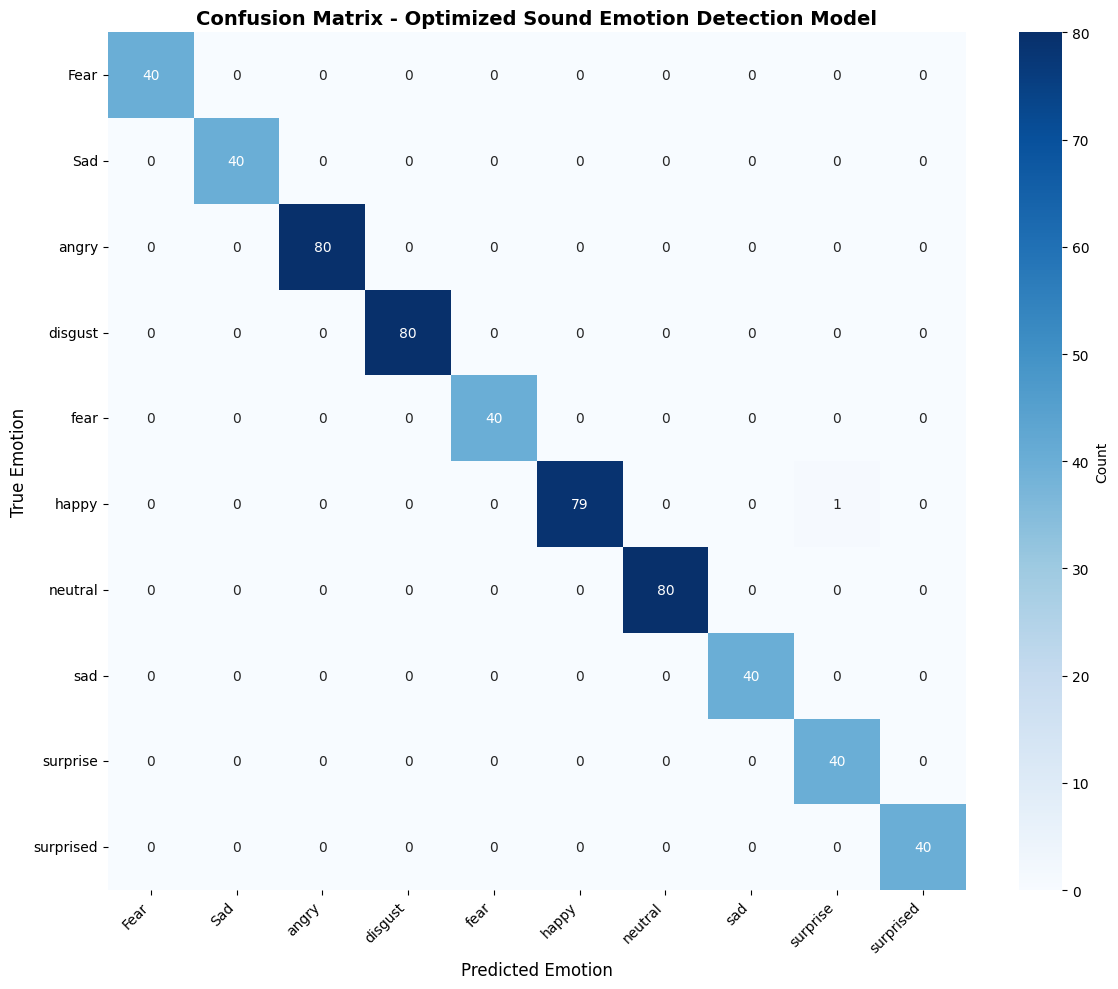


💾 Model saved to: ../model/optimized_sound_emotion_model.keras


In [16]:
# COMPREHENSIVE Model Evaluation
print("\n" + "=" * 60)
print("📊 COMPREHENSIVE MODEL PERFORMANCE EVALUATION")
print("=" * 60)

# Evaluate on all sets
train_loss, train_acc, train_top_k = model.evaluate(X_train, y_train_cat, verbose=0)
val_loss, val_acc, val_top_k = model.evaluate(X_val, y_val_cat, verbose=0)
test_loss, test_acc, test_top_k = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"\n📈 ACCURACY METRICS:")
print(f"  Training Accuracy:   {train_acc*100:.2f}%")
print(f"  Validation Accuracy: {val_acc*100:.2f}%")
print(f"  Test Accuracy:       {test_acc*100:.2f}%")
print(f"\n📉 LOSS METRICS:")
print(f"  Training Loss:   {train_loss:.4f}")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Test Loss:       {test_loss:.4f}")

# Bias-Variance Analysis
train_val_gap = abs(train_acc - val_acc)
val_test_gap = abs(val_acc - test_acc)

print(f"\n🔍 BIAS-VARIANCE ANALYSIS:")
print(f"  Train-Val Gap:   {train_val_gap*100:.2f}% ({'✓ Good' if train_val_gap < 0.05 else '⚠️ Overfitting' if train_val_gap > 0.1 else '→ Acceptable'})")
print(f"  Val-Test Gap:    {val_test_gap*100:.2f}% ({'✓ Good' if val_test_gap < 0.03 else '⚠️ Generalization issue' if val_test_gap > 0.05 else '→ Acceptable'})")

if train_val_gap < 0.05 and val_test_gap < 0.03:
    print(f"\n✅ EXCELLENT: Model shows good bias-variance tradeoff!")
elif train_val_gap < 0.1 and val_test_gap < 0.05:
    print(f"\n✓ GOOD: Model performance is acceptable")
else:
    print(f"\n⚠️ WARNING: Model may need further regularization")

# Generate predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

# Detailed Classification Report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
class_names = label_encoder.classes_
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Per-class accuracy
print(f"\n📊 PER-CLASS PERFORMANCE:")
for i, emotion in enumerate(class_names):
    if i in report:
        print(f"  {emotion:15s}: Precision={report[str(i)]['precision']:.3f}, "
              f"Recall={report[str(i)]['recall']:.3f}, "
              f"F1={report[str(i)]['f1-score']:.3f}")

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Optimized Sound Emotion Detection Model', fontsize=14, fontweight='bold')
plt.ylabel('True Emotion', fontsize=12)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save final model
model.save('../model/optimized_sound_emotion_model.keras')
print(f"\n💾 Model saved to: ../model/optimized_sound_emotion_model.keras")

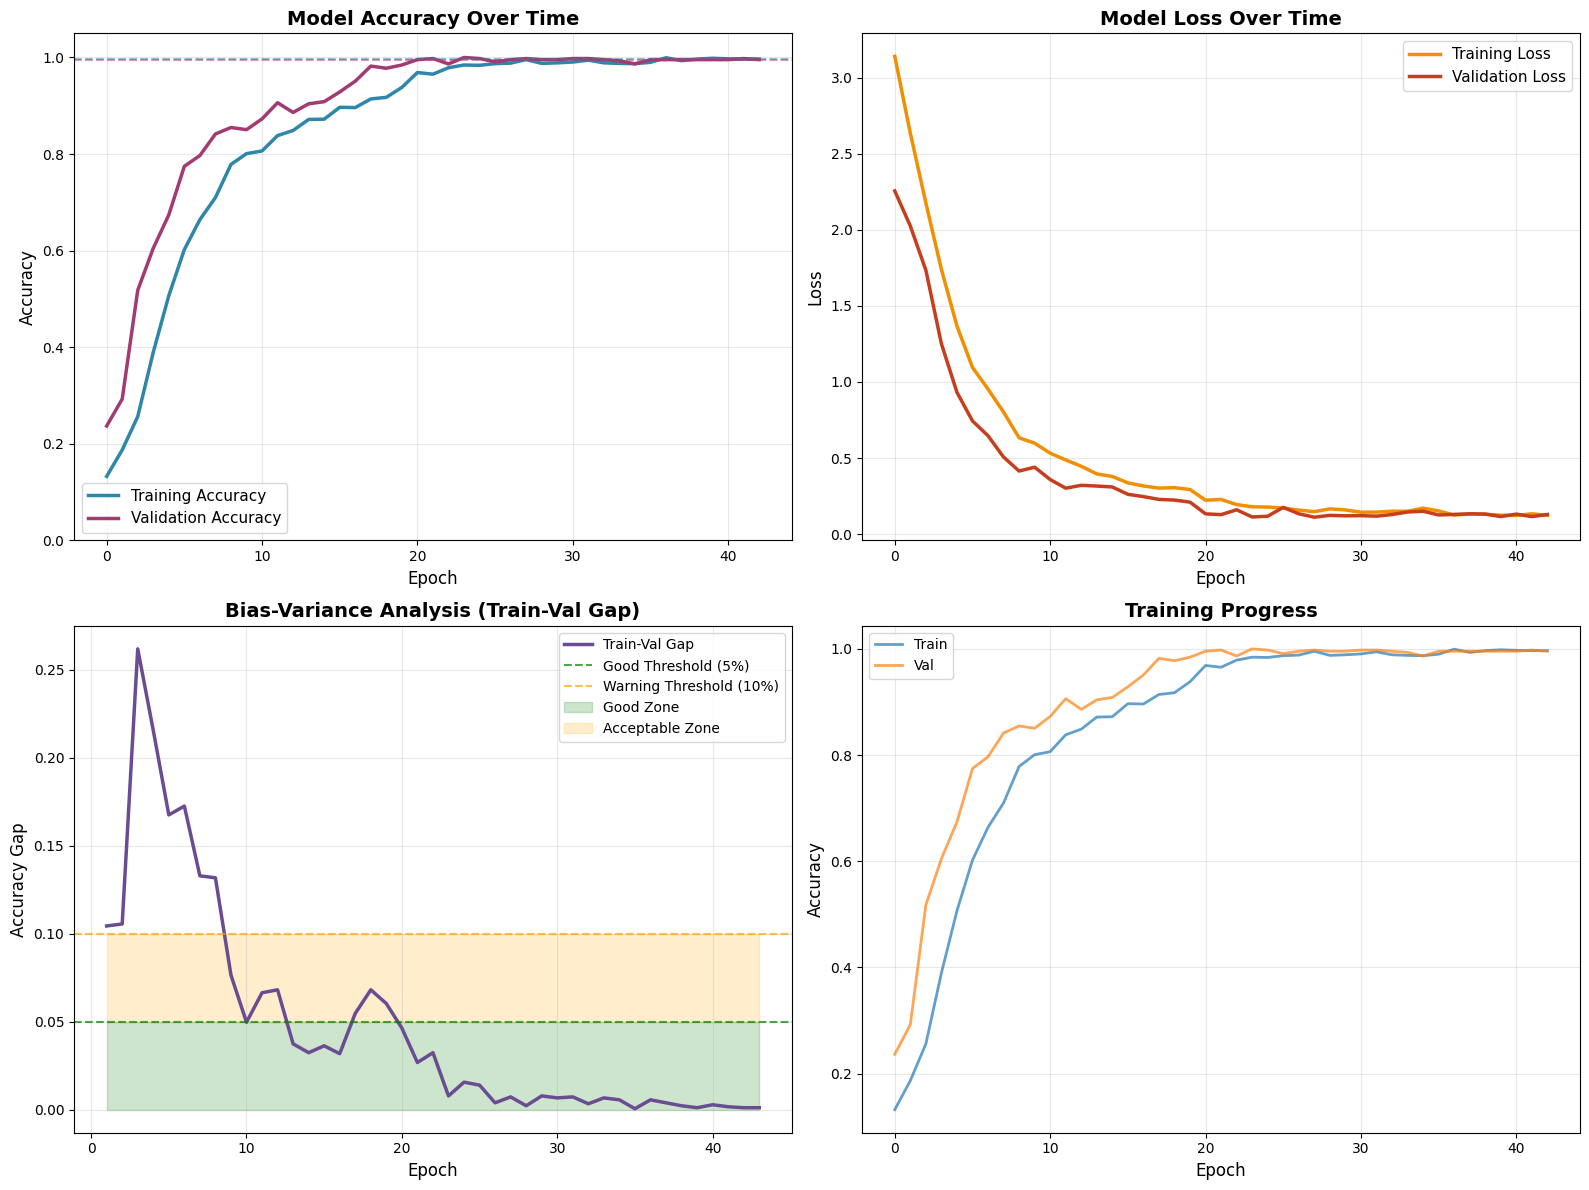


📊 TRAINING SUMMARY & BIAS-VARIANCE ANALYSIS

🎯 FINAL METRICS:
  Best Training Accuracy:   0.9994 (99.94%)
  Best Validation Accuracy: 1.0000 (100.00%)
  Final Training Accuracy:  0.9967 (99.67%)
  Final Validation Accuracy:0.9955 (99.55%)

📉 LOSS METRICS:
  Best Training Loss:   0.1225
  Best Validation Loss: 0.1109
  Final Training Loss:   0.1235
  Final Validation Loss: 0.1286

🔍 BIAS-VARIANCE ASSESSMENT:
  Final Train-Val Gap: 0.0011 (0.11%)
  Best Train-Val Gap:  0.0006 (0.06%)
  ✅ EXCELLENT: Model shows excellent generalization (gap < 5%)

📈 MODEL QUALITY:
  🏆 EXCELLENT: High accuracy with great generalization!


In [17]:
# COMPREHENSIVE Training History Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Plot
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2.5, color='#2E86AB')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5, color='#A23B72')
axes[0, 0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1.05])

# Calculate and display accuracy gap
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
acc_gap = abs(final_train_acc - final_val_acc)
axes[0, 0].axhline(y=final_train_acc, color='#2E86AB', linestyle='--', alpha=0.5, label=f'Train: {final_train_acc:.3f}')
axes[0, 0].axhline(y=final_val_acc, color='#A23B72', linestyle='--', alpha=0.5, label=f'Val: {final_val_acc:.3f}')

# 2. Loss Plot
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2.5, color='#F18F01')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#C73E1D')
axes[0, 1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Bias-Variance Analysis
epochs_range = range(1, len(history.history['accuracy']) + 1)
train_val_gap = [abs(t - v) for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
axes[1, 0].plot(epochs_range, train_val_gap, linewidth=2.5, color='#6A4C93', label='Train-Val Gap')
axes[1, 0].axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Good Threshold (5%)')
axes[1, 0].axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Warning Threshold (10%)')
axes[1, 0].fill_between(epochs_range, 0, 0.05, alpha=0.2, color='green', label='Good Zone')
axes[1, 0].fill_between(epochs_range, 0.05, 0.1, alpha=0.2, color='orange', label='Acceptable Zone')
axes[1, 0].set_title('Bias-Variance Analysis (Train-Val Gap)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy Gap', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Learning Rate Schedule
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2.5, color='#06A77D')
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    # If LR not tracked, show training progress
    axes[1, 1].plot(history.history['accuracy'], label='Train', alpha=0.7, linewidth=2)
    axes[1, 1].plot(history.history['val_accuracy'], label='Val', alpha=0.7, linewidth=2)
    axes[1, 1].set_title('Training Progress', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training Summary with Bias-Variance Metrics
print("\n" + "=" * 60)
print("📊 TRAINING SUMMARY & BIAS-VARIANCE ANALYSIS")
print("=" * 60)
print(f"\n🎯 FINAL METRICS:")
print(f"  Best Training Accuracy:   {max(history.history['accuracy']):.4f} ({max(history.history['accuracy'])*100:.2f}%)")
print(f"  Best Validation Accuracy: {max(history.history['val_accuracy']):.4f} ({max(history.history['val_accuracy'])*100:.2f}%)")
print(f"  Final Training Accuracy:  {history.history['accuracy'][-1]:.4f} ({history.history['accuracy'][-1]*100:.2f}%)")
print(f"  Final Validation Accuracy:{history.history['val_accuracy'][-1]:.4f} ({history.history['val_accuracy'][-1]*100:.2f}%)")

print(f"\n📉 LOSS METRICS:")
print(f"  Best Training Loss:   {min(history.history['loss']):.4f}")
print(f"  Best Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"  Final Training Loss:   {history.history['loss'][-1]:.4f}")
print(f"  Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# Bias-Variance Assessment
final_gap = abs(history.history['accuracy'][-1] - history.history['val_accuracy'][-1])
best_gap = abs(max(history.history['accuracy']) - max(history.history['val_accuracy']))

print(f"\n🔍 BIAS-VARIANCE ASSESSMENT:")
print(f"  Final Train-Val Gap: {final_gap:.4f} ({final_gap*100:.2f}%)")
print(f"  Best Train-Val Gap:  {best_gap:.4f} ({best_gap*100:.2f}%)")

if final_gap < 0.05:
    print(f"  ✅ EXCELLENT: Model shows excellent generalization (gap < 5%)")
elif final_gap < 0.1:
    print(f"  ✓ GOOD: Model shows good generalization (gap < 10%)")
elif final_gap < 0.15:
    print(f"  → ACCEPTABLE: Model shows acceptable generalization (gap < 15%)")
else:
    print(f"  ⚠️ WARNING: Model may be overfitting (gap > 15%)")

print(f"\n📈 MODEL QUALITY:")
if max(history.history['val_accuracy']) > 0.95 and final_gap < 0.05:
    print(f"  🏆 EXCELLENT: High accuracy with great generalization!")
elif max(history.history['val_accuracy']) > 0.90 and final_gap < 0.1:
    print(f"  ✅ VERY GOOD: High accuracy with good generalization")
elif max(history.history['val_accuracy']) > 0.85:
    print(f"  ✓ GOOD: Good accuracy, monitor for overfitting")
else:
    print(f"  → ACCEPTABLE: Consider further optimization")
print("=" * 60)

In [18]:
# Save the final model and components
model.save('../model/sound_emotion_detector.keras')
print("✅ Model saved as: ../model/sound_emotion_detector.keras")

# Save label encoder
joblib.dump(label_encoder, '../model/sound_emotion_label_encoder.pkl')
print("✅ Label encoder saved as: ../model/sound_emotion_label_encoder.pkl")

# Save model architecture
with open('../model/sound_emotion_model_info.txt', 'w') as f:
    f.write(f"Sound Emotion Detection Model\n")
    f.write(f"Input shape: {input_shape}\n")
    f.write(f"Number of classes: {n_classes}\n")
    f.write(f"Classes: {list(class_names)}\n")
    f.write(f"Sample rate: {sample_rate}\n")
    f.write(f"Duration: {duration} seconds\n")
    f.write(f"MFCC features: {n_mfcc}\n")

print("✅ Model information saved")
print("\n🎉 Sound Emotion Detection Model Training Complete!")

✅ Model saved as: ../model/sound_emotion_detector.keras
✅ Label encoder saved as: ../model/sound_emotion_label_encoder.pkl
✅ Model information saved

🎉 Sound Emotion Detection Model Training Complete!


In [19]:
# Test model on a new audio file
def predict_sound_emotion(audio_path, model, scaler, label_encoder, n_time_steps=173, n_features_per_step=62):
    """
    Predict emotion from audio file
    """
    # Extract features
    features = extract_audio_features(audio_path)
    
    if features is None:
        return None
    
    # Combine features along feature dimension
    # Each feature has shape (n_feat, time_steps)
    combined_features = np.concatenate([
        features['mfcc'],        # (40, time_steps)
        features['chroma'],     # (12, time_steps)
        features['spectral_contrast'],  # (7, time_steps)
        features['zcr'],       # (1, time_steps)
        features['spectral_rolloff'],   # (1, time_steps)
        features['rms']        # (1, time_steps)
    ], axis=0)
    
    # Flatten to 1D for StandardScaler (same as training pipeline)
    if combined_features.ndim == 1:
        combined_features = combined_features.ravel()
    elif combined_features.shape[1] == 1:
        # Only 1 time frame
        combined_features = combined_features.flatten()
    else:
        # Normal case: (total_features, time_steps) -> transpose and flatten
        combined_features = combined_features.T.flatten()
    
    # Ensure 1D
    if combined_features.ndim > 1:
        combined_features = combined_features.ravel()
    
    # Normalize - StandardScaler expects 2D: (n_samples, n_features)
    normalized_features = scaler.transform([combined_features])
    
    # Reshape for model: (n_samples, time_steps, n_features_per_step)
    total_features = normalized_features.shape[1]
    if total_features == n_time_steps * n_features_per_step:
        reshaped_features = normalized_features.reshape(1, n_time_steps, n_features_per_step)
    elif total_features % n_features_per_step == 0:
        inferred_time_steps = total_features // n_features_per_step
        reshaped_features = normalized_features.reshape(1, inferred_time_steps, n_features_per_step)
    else:
        raise ValueError(f"Cannot reshape features of size {total_features} into (time_steps, {n_features_per_step})")
    
    # Predict
    prediction = model.predict(reshaped_features, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # Decode label
    predicted_emotion = label_encoder.inverse_transform([predicted_class])[0]
    
    return {
        'emotion': predicted_emotion,
        'confidence': float(confidence),
        'all_probabilities': {
            label_encoder.inverse_transform([i])[0]: float(prob) 
            for i, prob in enumerate(prediction[0])
        }
    }

# Test on a sample file
if len(file_paths) > 0:
    test_file = file_paths[0]
    print(f"\nTesting on: {test_file}")
    
    # Use the same dimensions as training
    prediction = predict_sound_emotion(
        test_file, 
        model, 
        scaler, 
        label_encoder,
        n_time_steps=n_time_steps,
        n_features_per_step=n_features_per_step
    )
    
    if prediction:
        print(f"\n🎯 Prediction Results:")
        print(f"  Predicted emotion: {prediction['emotion']}")
        print(f"  Confidence: {prediction['confidence']:.4f} ({prediction['confidence']*100:.2f}%)")
        print(f"\n📊 All Probabilities:")
        for emotion, prob in sorted(prediction['all_probabilities'].items(), 
                                  key=lambda x: x[1], reverse=True):
            print(f"  {emotion:15s}: {prob:.4f} ({prob*100:.2f}%)")
    else:
        print("❌ Failed to predict emotion")
else:
    print("⚠️ No test files available. Run Cell 6 first to process audio files.")


Testing on: ../data/sound_data/TESS Toronto emotional speech set data/YAF_disgust/YAF_date_disgust.wav

🎯 Prediction Results:
  Predicted emotion: disgust
  Confidence: 0.9985 (99.85%)

📊 All Probabilities:
  disgust        : 0.9985 (99.85%)
  Sad            : 0.0007 (0.07%)
  sad            : 0.0003 (0.03%)
  surprised      : 0.0001 (0.01%)
  angry          : 0.0001 (0.01%)
  surprise       : 0.0001 (0.01%)
  neutral        : 0.0000 (0.00%)
  fear           : 0.0000 (0.00%)
  happy          : 0.0000 (0.00%)
  Fear           : 0.0000 (0.00%)
